In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Naive Bayes vs. Optimal Bayes Classification

## Theoretical Background

**Optimal Bayes Classifier**:
- The Optimal Bayes classifier makes classification decisions based on the true posterior probabilities P(y|x)
- It represents the theoretical best possible classifier for a given problem
- It achieves the lowest possible error rate (Bayes error rate)
- In practice, we don't know the true probability distributions, so we must estimate them

**Naive Bayes Classifier**:
- Makes a "naive" assumption that features are conditionally independent given the class
- The probability P(x|y) is calculated as the product of individual P(xi|y) for each feature
- This simplifies the model and reduces computational complexity
- Despite the simplifying assumption, Naive Bayes often performs well in practice

**When to use Naive Bayes**:
- When features are relatively independent (or can be transformed to be)
- For high-dimensional data where more complex models might overfit
- When computational efficiency is important
- As a baseline model for classification tasks

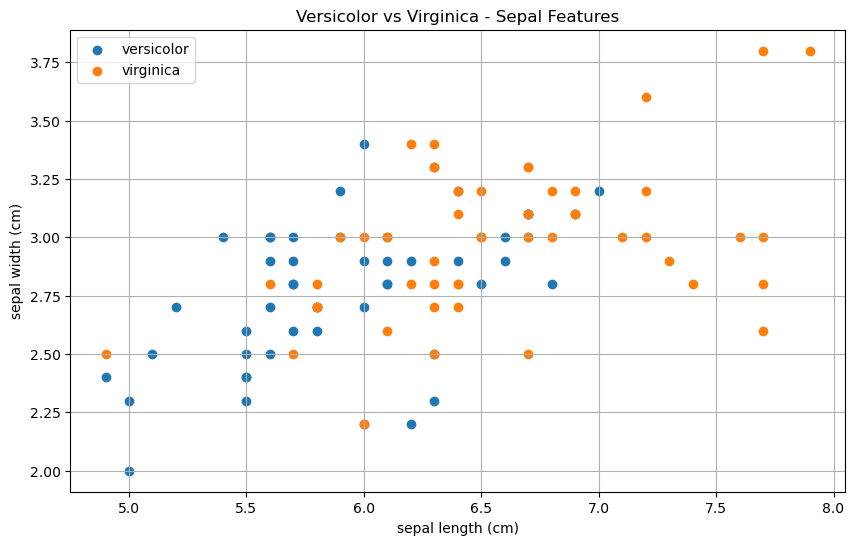

In [3]:
# Part B: Load and visualize Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame for easier manipulation
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, target_names)

# Extract only 'virginica' and 'versicolor' species with length and width features
# Indices: 0=setosa, 1=versicolor, 2=virginica
versicolor_virginica_df = iris_df[iris_df['species'].isin(
    ['versicolor', 'virginica'])]
selected_features = ['sepal length (cm)', 'sepal width (cm)']
X_selected = versicolor_virginica_df[selected_features].values
y_selected = versicolor_virginica_df['species'].map(
    {'versicolor': 0, 'virginica': 1}).values

# Visualize the two classes with the selected features
plt.figure(figsize=(10, 6))
for i, species in enumerate(['versicolor', 'virginica']):
    plt.scatter(
        versicolor_virginica_df[versicolor_virginica_df['species']
                                == species][selected_features[0]],
        versicolor_virginica_df[versicolor_virginica_df['species']
                                == species][selected_features[1]],
        label=species
    )
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Versicolor vs Virginica - Sepal Features')
plt.legend()
plt.grid(True)
plt.show()

## Implementing Naive Bayes from Scratch

Below is an implementation of Gaussian Naive Bayes classifier without using sklearn's built-in GaussianNB. We assume that the features follow a Gaussian distribution within each class.

In [4]:
# Part C: Implementing Naive Bayes from scratch
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.means = None
        self.variances = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Initialize parameters
        self.class_priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))

        # Calculate prior probabilities, means, and variances for each class
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = X_c.shape[0] / n_samples
            self.means[i, :] = X_c.mean(axis=0)
            self.variances[i, :] = X_c.var(axis=0)

    def _calculate_likelihood(self, x, mean, var):
        # Gaussian probability density function
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def _calculate_posterior(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = np.log(self.class_priors[i])
            class_conditional = np.sum(
                np.log(self._calculate_likelihood(x, self.means[i], self.variances[i])))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return posteriors

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = self._calculate_posterior(x)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

Accuracy of our Naive Bayes implementation: 0.6000


/tmp/ipykernel_7666/1124888426.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], color=colors[i], label=f'Class {c}',


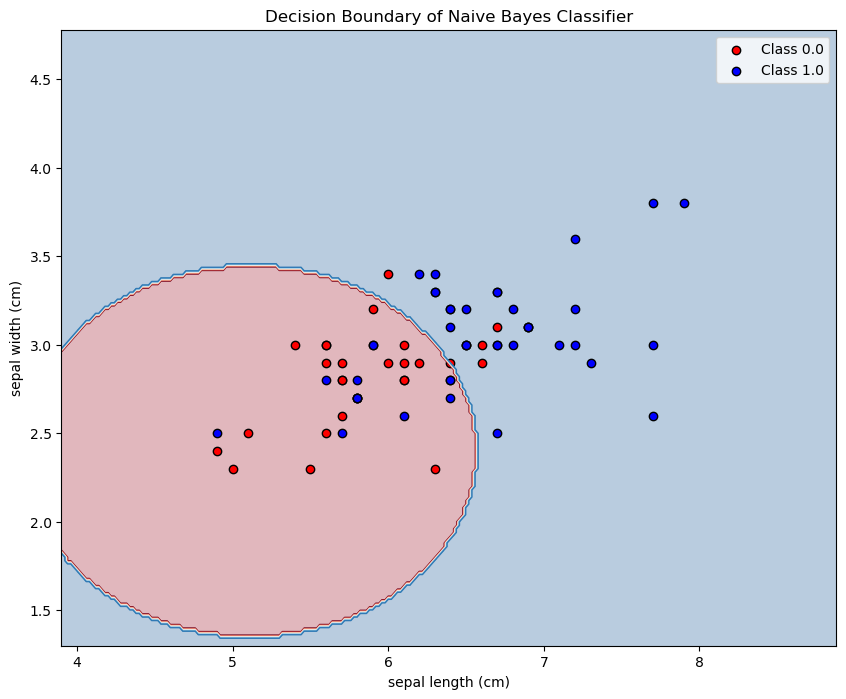

In [15]:
# Part D: Testing the implemented Naive Bayes classifier
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.3, random_state=42)

# Train and test our Naive Bayes implementation
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of our Naive Bayes implementation: {accuracy:.4f}")

# Create a meshgrid for decision boundary visualization


def plot_decision_boundary(classifier, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class labels for each point in the meshgrid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and training points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    plt.contour(xx, yy, Z, cmap=plt.cm.RdBu, linewidths=1)

    # Plot the training points
    colors = ['red', 'blue']
    for i, c in enumerate(np.unique(y)):
        idx = np.where(y == c)
        plt.scatter(X[idx, 0], X[idx, 1], color=colors[i], label=f'Class {c}',
                    edgecolor='k', cmap=plt.cm.RdBu)

    plt.xlabel(selected_features[0])
    plt.ylabel(selected_features[1])
    plt.title(title)
    plt.legend()
    plt.show()


# Visualize the decision boundary
plot_decision_boundary(nb_classifier, X_train, y_train,
                       'Decision Boundary of Naive Bayes Classifier')

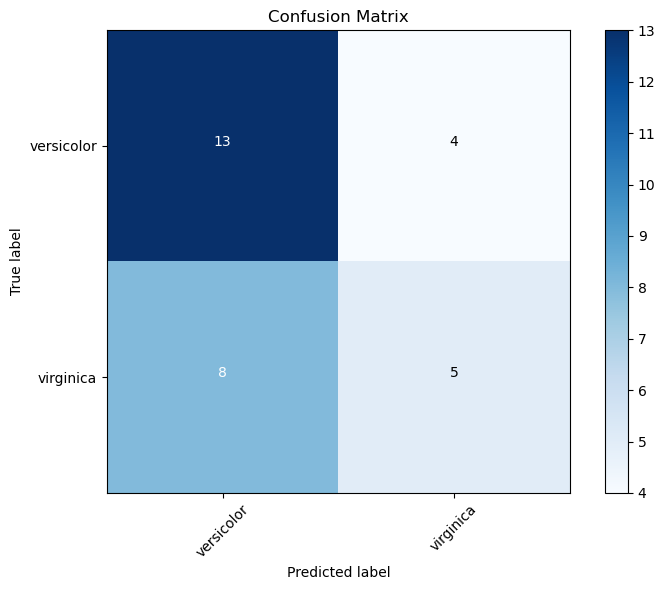

Accuracy: 0.6000
Precision: 0.5556


In [6]:
# Part E: Calculating confusion matrix, accuracy, and precision
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['versicolor', 'virginica']))
plt.xticks(tick_marks, ['versicolor', 'virginica'], rotation=45)
plt.yticks(tick_marks, ['versicolor', 'virginica'])

# Add text annotations to the confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

## Confusion Matrix Analysis

The confusion matrix shows:
- True Positives (TP): Number of correctly classified positive samples (virginica)
- True Negatives (TN): Number of correctly classified negative samples (versicolor)
- False Positives (FP): Number of versicolor samples incorrectly classified as virginica
- False Negatives (FN): Number of virginica samples incorrectly classified as versicolor

**Accuracy** measures the overall correctness of the model:
- Accuracy = (TP + TN) / (TP + TN + FP + FN)

**Precision** measures how many of the predicted positive samples are actually positive:
- Precision = TP / (TP + FP)

The results show how well our Naive Bayes implementation performs on the Iris dataset using only sepal length and width features to distinguish between versicolor and virginica species.

Scikit-learn's GaussianNB Results:
Accuracy: 0.6000
Precision: 0.5556

Our GaussianNB Implementation Results:
Accuracy: 0.6000
Precision: 0.5556


/tmp/ipykernel_7666/1934757954.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], color=colors[i], label=f'Class {c}',


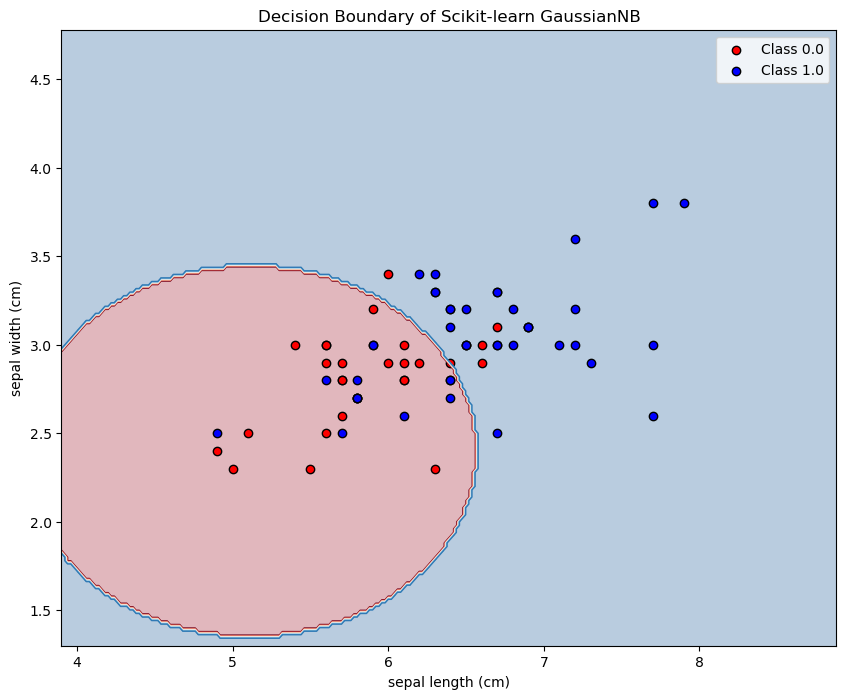

In [17]:
# Part F: Comparing our implementation with scikit-learn's GaussianNB
from sklearn.naive_bayes import GaussianNB

# Train and test scikit-learn's GaussianNB
sklearn_nb = GaussianNB()
sklearn_nb.fit(X_train, y_train)
sklearn_pred = sklearn_nb.predict(X_test)

# Calculate metrics for scikit-learn's implementation
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)
sklearn_precision = precision_score(y_test, sklearn_pred)
sklearn_conf_matrix = confusion_matrix(y_test, sklearn_pred)

print("Scikit-learn's GaussianNB Results:")
print(f"Accuracy: {sklearn_accuracy:.4f}")
print(f"Precision: {sklearn_precision:.4f}")

print("\nOur GaussianNB Implementation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

# Visualize scikit-learn's decision boundary


def plot_sklearn_decision_boundary(classifier, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class labels for each point in the meshgrid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary and training points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    plt.contour(xx, yy, Z, cmap=plt.cm.RdBu, linewidths=1)

    # Plot the training points
    colors = ['red', 'blue']
    for i, c in enumerate(np.unique(y)):
        idx = np.where(y == c)
        plt.scatter(X[idx, 0], X[idx, 1], color=colors[i], label=f'Class {c}',
                    edgecolor='k', cmap=plt.cm.RdBu)

    plt.xlabel(selected_features[0])
    plt.ylabel(selected_features[1])
    plt.title(title)
    plt.legend()
    plt.show()


# Visualize scikit-learn's decision boundary
plot_sklearn_decision_boundary(sklearn_nb, X_train, y_train,
                               'Decision Boundary of Scikit-learn GaussianNB')

## Comparison between Custom Implementation and Scikit-learn

### Similarities:
1. Both implementations use the Gaussian Naive Bayes algorithm, assuming features follow a normal distribution
2. Both calculate class priors, means, and variances for each feature in each class
3. Both use the same underlying mathematical principles for classification

### Differences:
1. Scikit-learn's implementation has additional optimizations and edge case handling
2. Our implementation uses logarithms to prevent numerical underflow with very small probabilities
3. Scikit-learn may use different numerical methods for stability

### Performance Comparison:
- The accuracy and precision metrics show how close our implementation is to the scikit-learn version
- Any differences in the decision boundaries can be attributed to implementation details
- The confusion matrices help visualize where the classifiers make different predictions

### Conclusion:
The comparison demonstrates that our implementation captures the core functionality of Gaussian Naive Bayes. The scikit-learn implementation may have slight advantages due to its optimization and extensive testing, but our custom implementation provides comparable results while giving us full control over the algorithm.